# Predict Whether or not a Customer Will Purchase a Quote:

**Importing Relevant Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import *
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV

from imblearn.over_sampling import SMOTE

Import the dataset and store as "df".

In [2]:
df = pd.read_csv("DS_Assessment_Dataset.csv")
df.head()

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Date,Marital_Status,Sale
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,29/05/2016,M,0
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,03/07/2015,S,0
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,04/10/2015,M,0
3,32.0,10000.0,38.572157,385.721570,7000.0,493.840343,9.165431,22/09/2016,S,0
4,28.0,9000.0,33.317349,333.173490,5000.0,416.459533,6.810972,08/09/2015,M,0


## EDA:

**Check the df for missing values:**

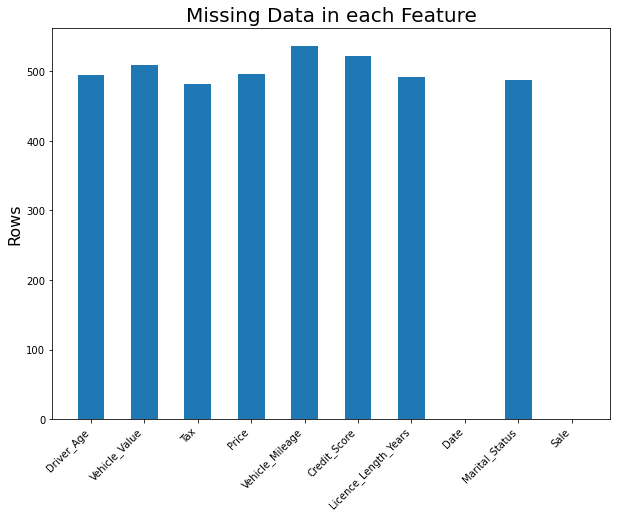

In [3]:
def missing_data_plot(size):
    labels = list(df.columns)
    na_values = []
    values = []
    percentage = []
    width = 0.5

    for feature in labels:
        na_values.append(sum(df[feature].isna()))
        values.append(sum(df[feature].notna()))
        percentage.append(round(100*sum(df[feature].notna())/len(df[feature]),1))

    fig, ax = plt.subplots(figsize=(size))

    ax.bar(labels, na_values, width)

    ax.set_ylabel('Rows', fontsize=16)
    ax.set_title('Missing Data in each Feature', fontsize=20)
    fig.autofmt_xdate(rotation=45)

    plt.show()
    
missing_data_plot((10,8))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driver_Age            49506 non-null  float64
 1   Vehicle_Value         49491 non-null  float64
 2   Tax                   49519 non-null  float64
 3   Price                 49504 non-null  float64
 4   Vehicle_Mileage       49464 non-null  float64
 5   Credit_Score          49478 non-null  float64
 6   Licence_Length_Years  49508 non-null  float64
 7   Date                  50000 non-null  object 
 8   Marital_Status        49512 non-null  object 
 9   Sale                  50000 non-null  int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 3.8+ MB


- From the above plot and info call it is possible to see that all of the features are missing values except "Sale" and "Date".
- The feature missing the most data is "Vehicle_Mileage", with 1% of its data missing.

As there are very few NA values I could either remove them, or set them equal to the mean of their respective columns.
- I will set them equal to the mean of their columns, unless there is some obvious correlation between variables:

The date feature is currently a string so I'll change this to a datatime object:

In [5]:
df["Date"] = pd.to_datetime(df["Date"], format = "%d/%m/%Y", errors = "coerce")

Price and Tax show a unique linear relationship with Price = 10 * Tax or Price = 20 * Tax. For these features i'll try and fill in the missing values with either P=10 * T or P=20 * T, but i need to first find out why there are two relationships.

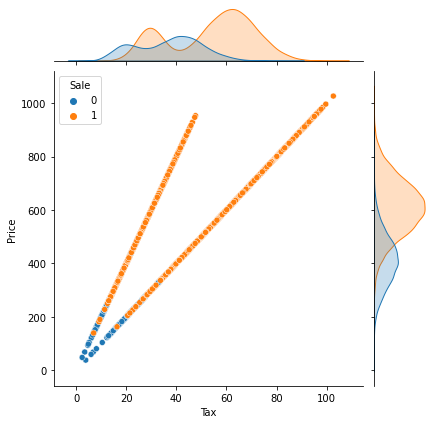

In [6]:
_=sns.jointplot(data=df, x="Tax", y="Price", hue="Sale")

I want to find out why these varaibles fall into either one of these two lines. I will divide the dataframe into these two groups (P=10 * T and P=20 * T) and then try and find a reason for why this happens.

In [7]:
# creates a dataframe with rows in which p=20*T holds true:
df_P20 = df[df["Price"] > df["Tax"]*11]

In [8]:
# creates a dataframe with rows in which p=10*T holds true:
df_P10 = df[df["Price"] <= df["Tax"]*11]

The two relationships are possibly down to date?

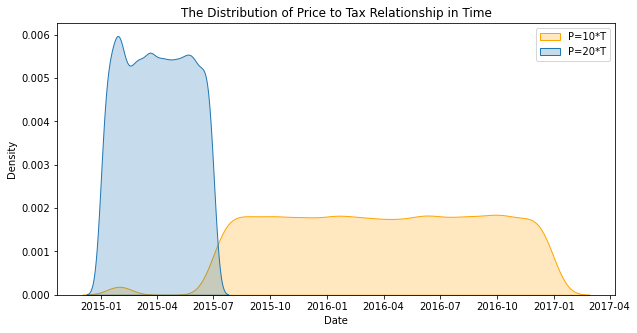

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.kdeplot(data=df_P10, x="Date", shade=True, color="orange")
ax=sns.kdeplot(data=df_P20, x="Date", shade=True)
ax.legend(["P=10*T","P=20*T"], loc='upper right')
_=ax.set_title("The Distribution of Price to Tax Relationship in Time")

The above plot shows that these two relationships of Price and Tax can be seperated quite well using a time cut off around july 2015. For all missing Tax and Price values I can now use the time of insurance inquiry to determine which relationship to use, if T > 07/2015 then P=10 * T, if T <= 07/2015 then P=20 * T. If both Price and Tax is missing i will fill this with the mean value.

In [10]:
# The code below fills in the missing price and tax values with either P=10 * T or P=20 * T:

def price_tax_date(x, Tax = False, Price = False):
    if Tax:
        # check the element is NaN
        if math.isnan(x[0]):
            # split decision on date
            if x[2] > date(2015, 7, 1):
                # T = P/10
                x[0] = x[1]/10
                return x
            else:
                # T = P/20
                x[0] = x[1]/20
                return x
        else:
            return x
        
    if Price:
        # check the element is NaN
        if math.isnan(x[0]):
            # split decision on date
            if x[2] > date(2015, 7, 1):
                # P = 10*T
                x[0] = x[1]*10
                return x
            else:
                # P = 20*T
                x[0] = x[1]*20
                return x
        else:
            return x

In [11]:
# This code calls the above function and updates the missing values for Price and Tax
df["Tax"] = df[["Tax","Price","Date"]].apply(lambda x: price_tax_date(x, Tax=True), axis=1)
df["Price"] = df[["Price","Tax","Date"]].apply(lambda x: price_tax_date(x, Price=True), axis=1)

In [12]:
# 5 values where both Tax and Price are NaN, will put these equal to mean later.
df[(df["Price"].isnull()) & (df["Tax"].isnull())]

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Date,Marital_Status,Sale
9296,33.0,10000.0,NaN,NaN,6000.0,398.862743,9.671785,2016-12-26,M,0
15656,30.0,10000.0,NaN,NaN,8000.0,321.134271,9.631155,2016-05-08,M,1
18986,29.0,8000.0,NaN,NaN,7000.0,263.487634,7.456764,2016-06-05,S,1
19038,28.0,7000.0,NaN,NaN,8000.0,391.688520,7.967639,2015-04-15,S,1
28522,23.0,6000.0,NaN,NaN,10000.0,330.382930,3.134085,2015-02-20,M,1


Now I can put all the missing values of the other features equal to their respective mean values:

In [13]:
# loops through each feature and sets the NA values equal to the mean (for float type) or mode (for string type)
for feature in df.columns:
    # only looks at features with NA values
    if any(df[feature].isna()):
        # matiral status is string type so different code required:
        if feature == "Marital_Status":
            # select mode
            val = df[feature].value_counts().index[0]
            df[feature].isna()
            df[feature] = df[feature].apply(lambda x: val if x!=x else x)
        else:
            # select mean
            val = df[feature].mean()
            df[feature] = df[feature].apply(lambda x: val if math.isnan(x) else x)

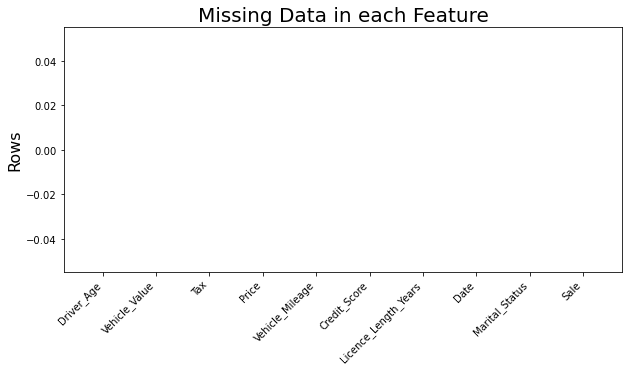

In [14]:
missing_data_plot((10,5))

The above plot shows that there are no missing values anymore.

**Checking for labelled data class balance:**

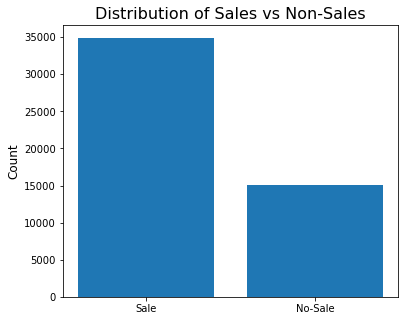

In [15]:
fig, ax = plt.subplots(figsize=(6,5))
labels = ["Sale", "No-Sale"]
ax.bar(labels, df["Sale"].value_counts())
ax.set_title("Distribution of Sales vs Non-Sales", fontsize=16)
ax.set_ylabel("Count", fontsize=12)
plt.show()

Large imbalance in labelled dataset, will consider oversampling minority dataset to improve model performance later on.

**Credit Score Outliers**

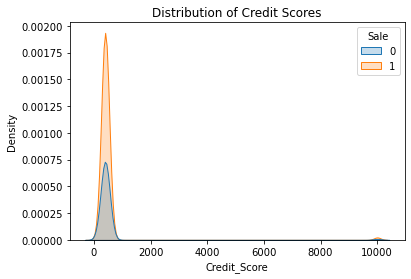

In [16]:
_=sns.kdeplot(data=df, x="Credit_Score", hue="Sale", shade=True)
_=plt.title("Distribution of Credit Scores")

There are outliers around 10000.

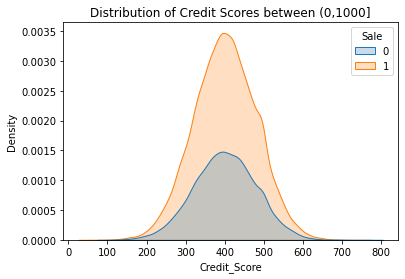

In [17]:
_=sns.kdeplot(data=df[df["Credit_Score"] <= 1000], x="Credit_Score", hue="Sale", shade=True)
_=plt.title("Distribution of Credit Scores between (0,1000]")

The above plots shows the distribution of credit scores in the range of 0-1000. 

I want to know what are the values of the outliers and there frequency?

In [18]:
# This shows the customers credit score and the number of these credict scores:
df[df["Credit_Score"] > 1000]["Credit_Score"].value_counts()

9999.0    500
Name: Credit_Score, dtype: int64

The above code shows that all the outliers are 9999 and there is 500 of them.

Is there a difference in the of percentage of sales for the group between 0-1000 and the outlier group?

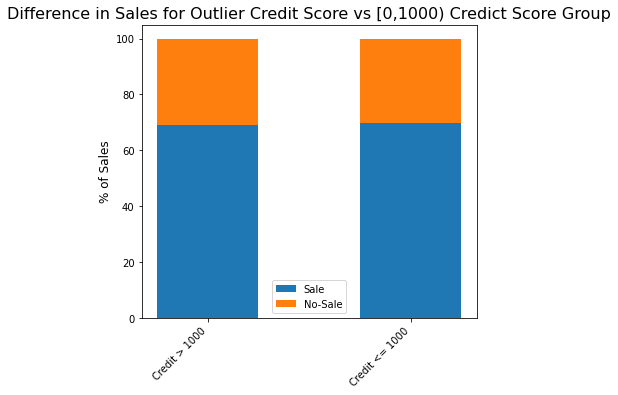

In [19]:
labels = ["Credit > 1000", "Credit <= 1000"]
sale_df_1 = 100*df[df["Credit_Score"] > 1000]["Sale"].value_counts()/sum(df[df["Credit_Score"] > 1000]["Sale"].value_counts())
sale_df_2 = 100*df[df["Credit_Score"] <= 1000]["Sale"].value_counts()/sum(df[df["Credit_Score"] <= 1000]["Sale"].value_counts())
less_1000 = [sale_df_1[0], sale_df_2[0]]
more_1000 = [sale_df_1[1], sale_df_2[1]]
width = 0.5

fig, ax = plt.subplots(figsize=(6,6))

ax.bar(labels, more_1000, width, label='Sale')
ax.bar(labels, less_1000, width, bottom=more_1000,
       label='No-Sale')

ax.set_ylabel('% of Sales', fontsize=12)
ax.set_title('Difference in Sales for Outlier Credit Score vs [0,1000) Credict Score Group', fontsize=16)
ax.legend()
fig.autofmt_xdate(rotation=45)

plt.show()

The plot above shows that the percentage of sales and non-sales is the same for both the credict scores <= 1000 and > 1000.

I will put all these outlier credit score equal to the mean.

In [20]:
df["Credit_Score"] = df["Credit_Score"].apply(lambda x: df["Credit_Score"].mean() if x > 1000 else x)

Below is a plot of the new distribution of customers Credict Scores for Sales and Non-Sales

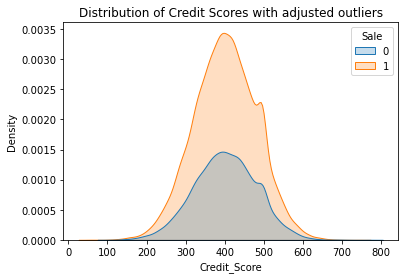

In [21]:
_=sns.kdeplot(data=df, x="Credit_Score", hue="Sale", shade=True)
_=plt.title("Distribution of Credit Scores with adjusted outliers")

**Checking interaction of numerical features:**

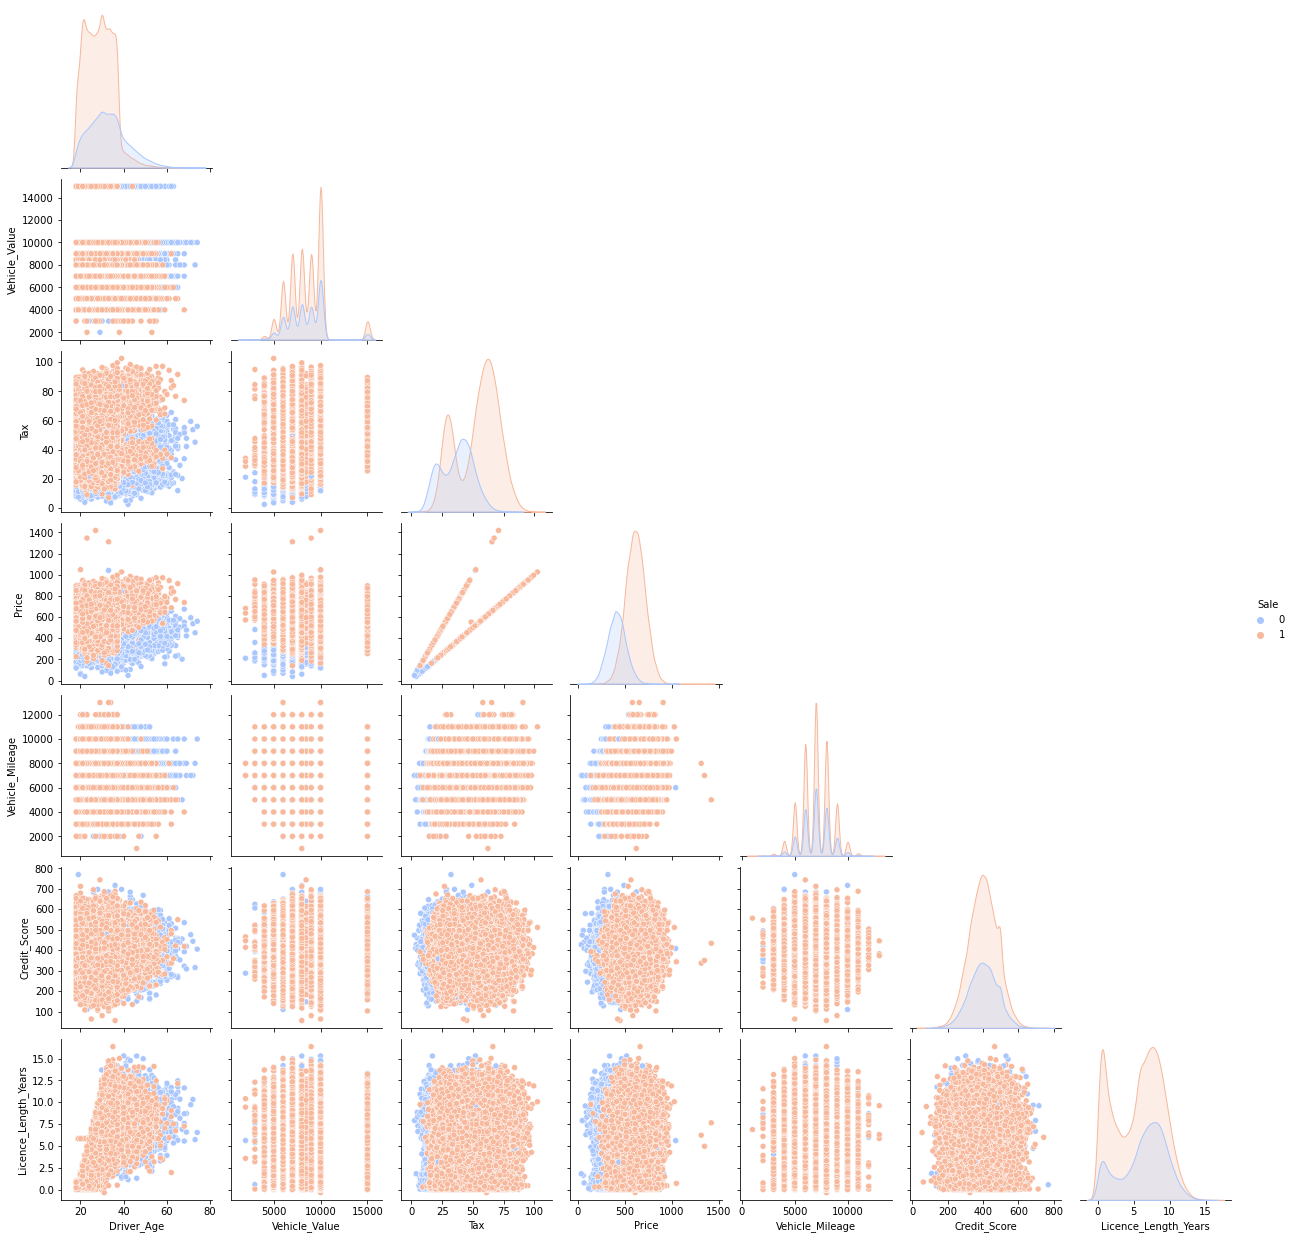

In [22]:
sns.pairplot(df, hue="Sale", corner=True, kind="scatter", palette="coolwarm")

From the plot above the follwing has been observed:

- The distributions of Price and Tax seem to be the most dissimilar (seen on the diagonal), this means that these features will be important in helping the machine learning model determine if a customer will purchase insurance.
- Driver age and Price has a large roughly linearly seperable space in the bottom right of its plot, this might be an important feature combination.
- Driver age and Tax also has a some seperation, this is also in the bottom right of the plot.
- As we've already seen price and tax has 2 linear realationships.

**Checking the correlation between variable pairs:**

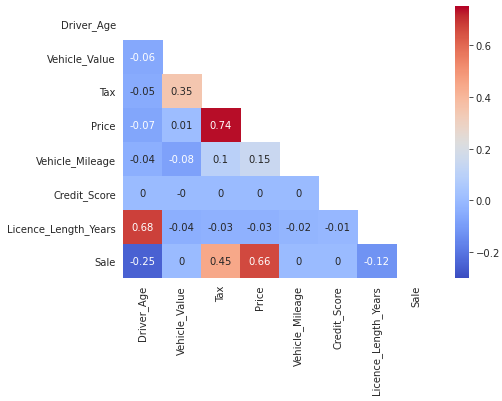

In [23]:
df_corr = round(df.corr(),2)
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(df_corr, mask=mask, vmax=.75, vmin=-0.3, cmap="coolwarm", annot=True)

The above heatmap shows which variables have a high or low correlation within their pairs. The most important part of this plot is the last row which shows which variables have a high correlation to sales. The price and tax have the largest correlation, meaning that if price increases so does the number of sales, the same is true for the vehicle tax. The drivers age and licence length are negatively correlated, meaning that younger drivers are more willing to purchase insurance. 

Interestingly the other variables have little correlation to sales, however, this doesnt necessarily mean they have little impact on the sales, I'll need to investigate this later on.

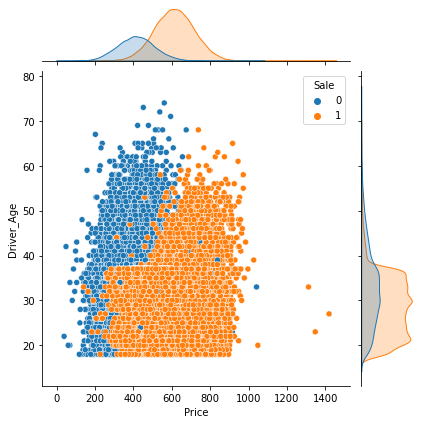

In [24]:
_=sns.jointplot(data=df, x="Price", y="Driver_Age", hue="Sale", kind="scatter")

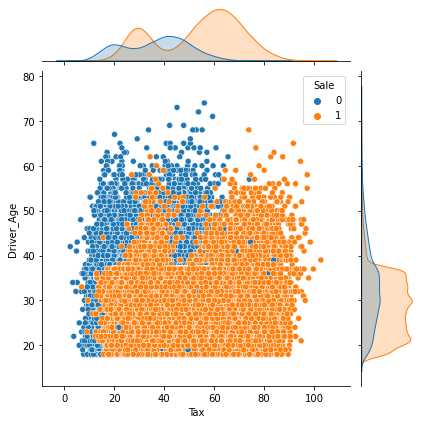

In [25]:
_=sns.jointplot(data=df, x="Tax", y="Driver_Age", hue="Sale", kind="scatter")

The two jointplots above show two combinations of features that show good seperation of the labelled data. If I need to improve ML performance later on i could try using a n-polynomial combination of these as new features. 

**Feature Distributions and Outliers**

Removing redundant outliers can greatly improve machine learning performance. This is because it allows for an improved seperability of the data, meaning the ML model can find a clear decision boundary.

None
None
None
None
None
None
None


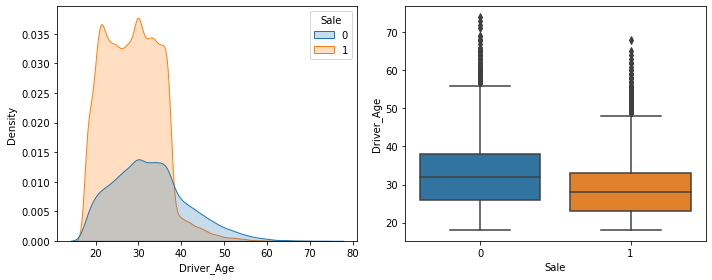

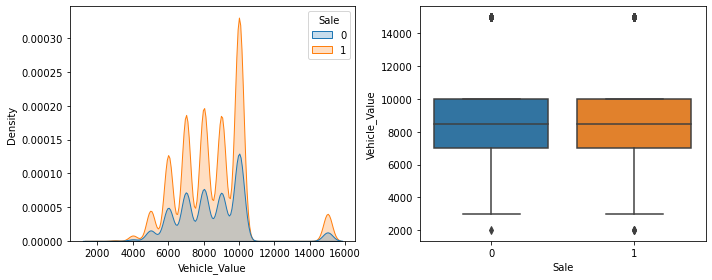

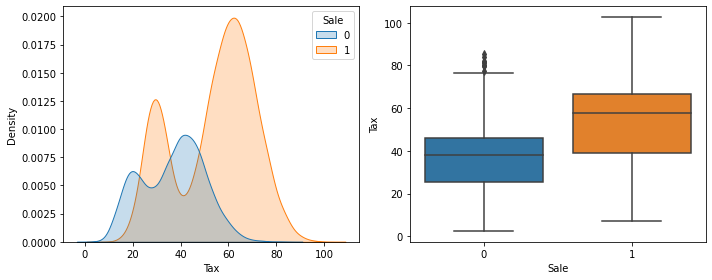

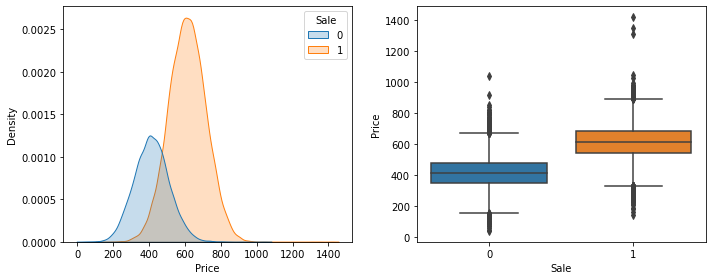

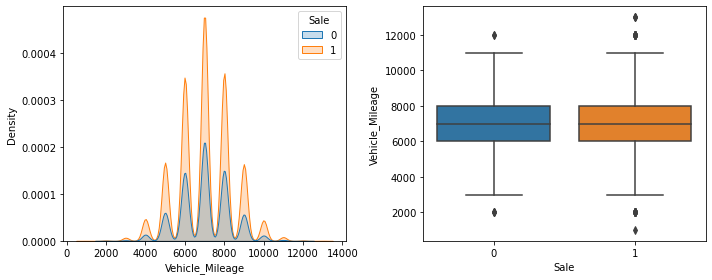

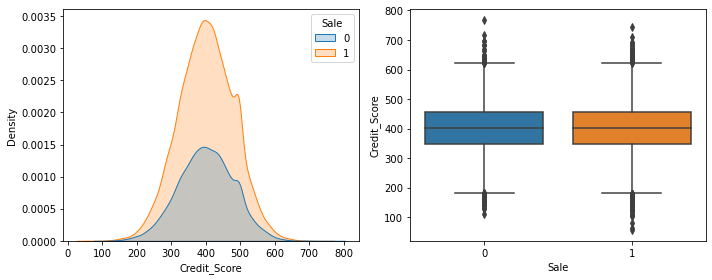

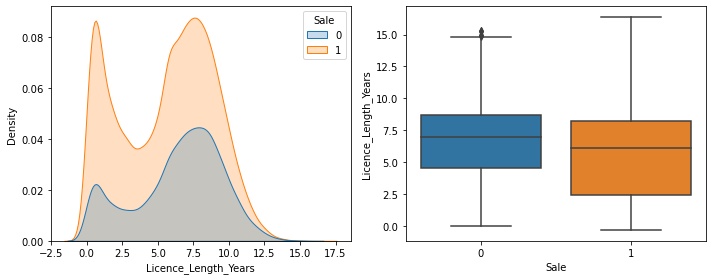

In [26]:
def distribution_box(a,b):

    fig, ax = plt.subplots(1,2, figsize=(10,4))

    sns.kdeplot(data = df, x=a, shade=True, hue=b, ax=ax[0])
    sns.boxplot(data= df, x=b, y=a, ax=ax[1])

    plt.tight_layout()
    return None

for f in df.columns.drop(["Date","Marital_Status","Sale"]):
    print(distribution_box(f,"Sale"))

The above plots show that price, tax and driver age have distributions that are the most different between sale and non-sale data. These will probably be the most important feature when moving onto the machine learning section. Removing the outliers for these features will be the most impactful, however, as a good measure i'll also remove the outliers for the other features.

I will remove the outliers for both the sale and non-sale data. If I removed outliers of the entire feature this would result in some form of warping of the distributions, which might hurt later modelling.

In [27]:
# how to find the different quartiles for the data.
def quartiles(data):
    q25, q50, q75 = np.percentile(data, [25, 50, 75])
    # iqr = inner quartile range
    iqr = q75 - q25

    q0 = q25 - 1.5*iqr
    q100 = q75 + 1.5*iqr
    
    return q0, q25, q50, q75, q100

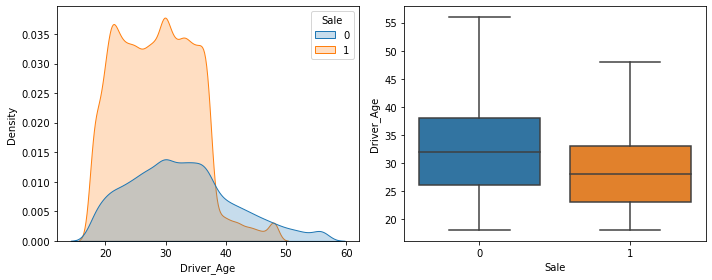

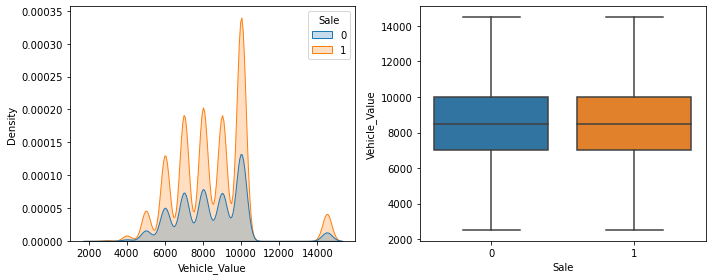

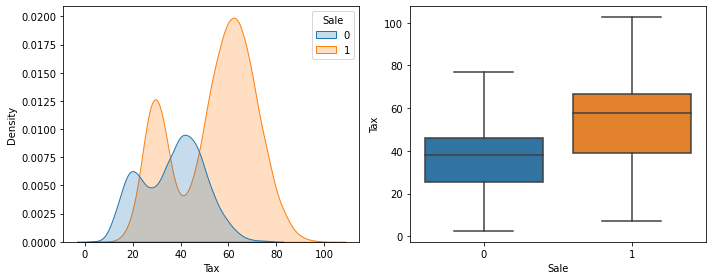

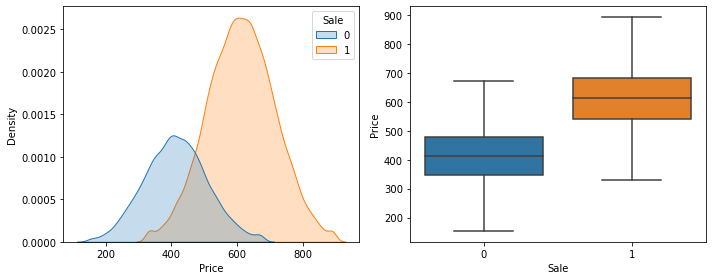

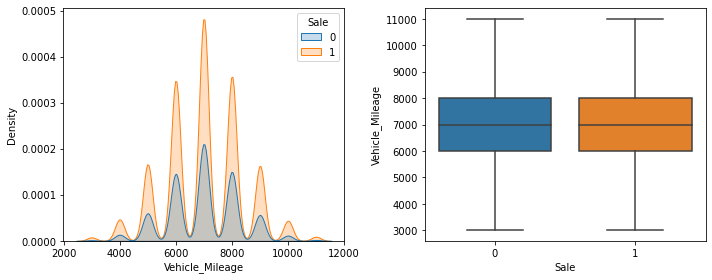

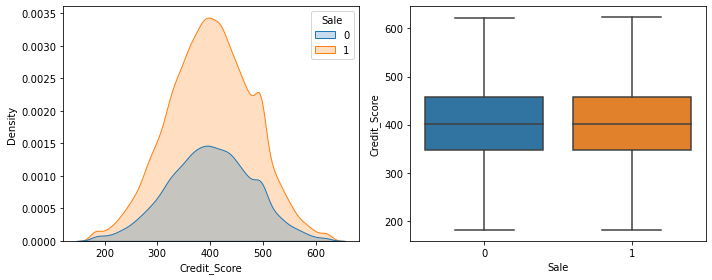

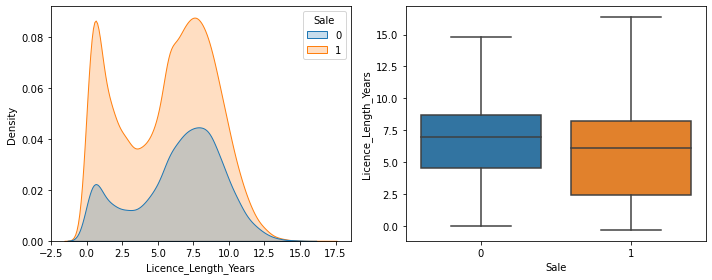

In [28]:
def remove_outliers(feature):
    # split the data into sale and non-sale for all features:
    data_no_sale = df[df["Sale"]==0][feature]
    data_sale = df[df["Sale"]==1][feature]
    
    # set the thresholds for the sale and non-sale feature
    threshold_high_no_sale = quartiles(data_no_sale)[-1]
    threshold_low_no_sale = quartiles(data_no_sale)[0]
    threshold_high_sale = quartiles(data_sale)[-1]
    threshold_low_sale = quartiles(data_sale)[0]
    
    # puts outliers equal to the min or max of the quartiles for non-sale
    def filter_nosale(x):
        if x[1] == 0 and x[0] > threshold_high_no_sale:
            x[0] = threshold_high_no_sale
            return x
        elif x[1] == 0 and x[0] < threshold_low_no_sale:
            x[0] = threshold_low_no_sale
            return x
        else:
            return x
    
    # puts outliers equal to the min or max of the quartiles for sale
    def filter_sale(x):
        if x[1] == 1 and x[0] > threshold_high_sale:
            x[0] = threshold_high_sale
            return x
        elif x[1] == 1 and x[0] < threshold_low_sale:
            x[0] = threshold_low_sale
            return x
        else:
            return x
    
    # applies the functions above to each row of the dataset
    df[feature] = df[[feature,"Sale"]].apply(lambda x: filter_nosale(x), axis=1)
    df[feature] = df[[feature,"Sale"]].apply(lambda x: filter_sale(x), axis=1)
    
    # plots the new distribution and outliers
    fig, ax = plt.subplots(1,2, figsize=(10,4))

    sns.kdeplot(data = df, x=f, shade=True, hue="Sale", ax=ax[0])
    sns.boxplot(data= df, x="Sale", y=f, ax=ax[1])

    plt.tight_layout()

# loops through all the numerical features
for f in df.columns.drop(["Date","Marital_Status","Sale"]):
    remove_outliers(f)

The above distributions have remained roughly the same, however, now there are no outliers.

**Investigating the Datetime**

In [29]:
df_ = df.copy()
df_.head()

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Date,Marital_Status,Sale
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,2016-05-29,M,0
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,2015-07-03,S,0
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,2015-10-04,M,0
3,32.0,10000.0,38.572157,385.721570,7000.0,493.840343,9.165431,2016-09-22,S,0
4,28.0,9000.0,33.317349,333.173490,5000.0,416.459533,6.810972,2015-09-08,M,0


I want to split the date into year, month, week, day, and weekday columns for further investigation

In [30]:
df_["Year"] = df_["Date"].dt.year
df_["Month"] = df_["Date"].dt.month
df_["Week"] = df_["Date"].dt.week
df_["Day"] = df_["Date"].dt.day
df_["Week Day"] = df_["Date"].dt.weekday.map({0:"Monday", 1:"Tuesday", 2:"Wednesday",
                3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"})

<ipython-input-30-97f25382f62c>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_["Week"] = df_["Date"].dt.week


In [31]:
df_.head()[df_.columns[-6:]]

,Sale,Year,Month,Week,Day,Week Day
0,0,2016,5,21,29,Sunday
1,0,2015,7,27,3,Friday
2,0,2015,10,40,4,Sunday
3,0,2016,9,38,22,Thursday
4,0,2015,9,37,8,Tuesday


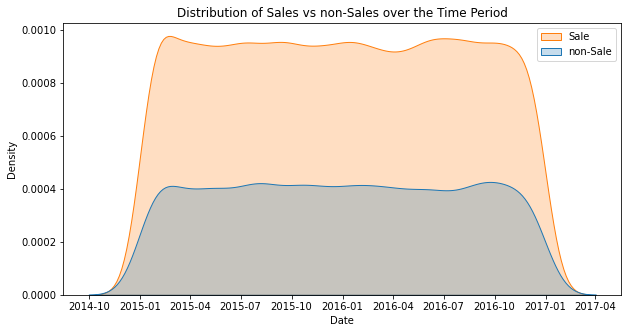

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.kdeplot(data=df_, x="Date", shade=True, color="orange", hue="Sale")
ax.legend(["Sale","non-Sale"], loc='upper right')
_=ax.set_title("Distribution of Sales vs non-Sales over the Time Period")

Sales and non-sales over the period stay relatively constant over time.

How are the sale effected over the months of the year?

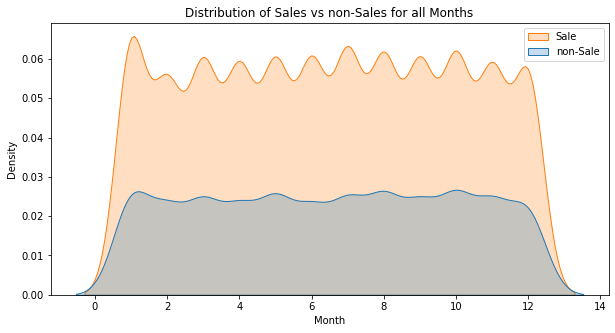

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.kdeplot(data=df_, x="Month", shade=True, color="orange", hue="Sale")
ax.legend(["Sale","non-Sale"], loc='upper right')
_=ax.set_title("Distribution of Sales vs non-Sales for all Months")

There are spikes in purchases for all months at the end of the month, with January being the largest increase in sales, and Febuary being the smallest increase.

I would like to see how customers sales and non-sale data is distributed for all days in all months, perhaps there is a specific day of the month (e.g. 31st) or weekday (e.g. friday) that has more customer enquiries than other days?

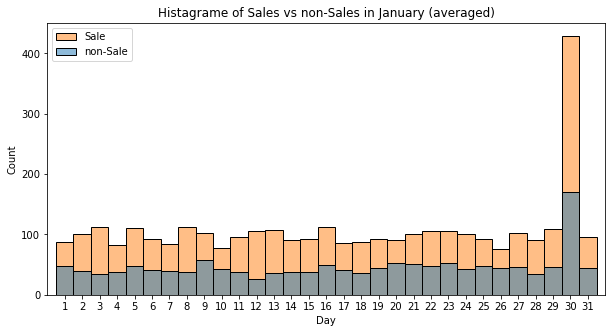

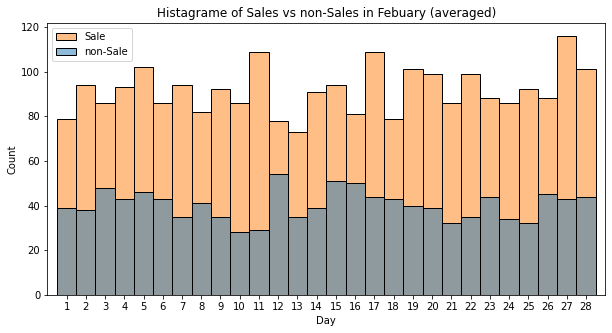

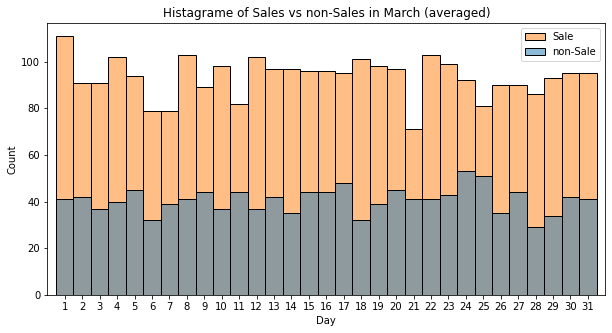

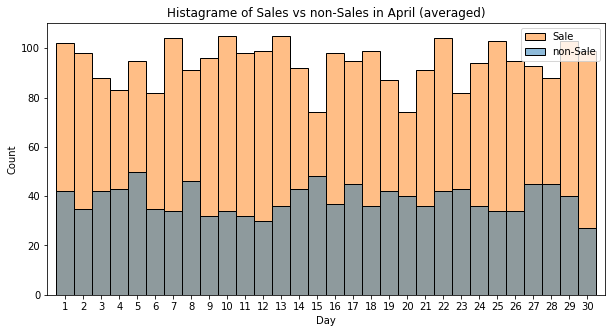

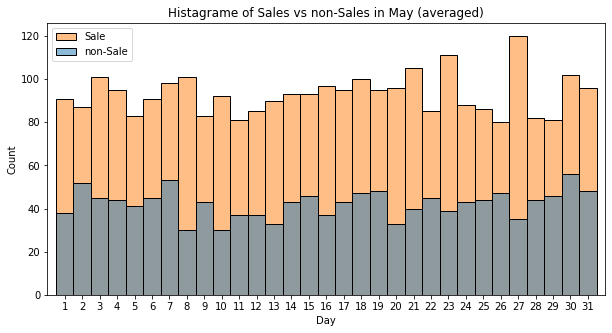

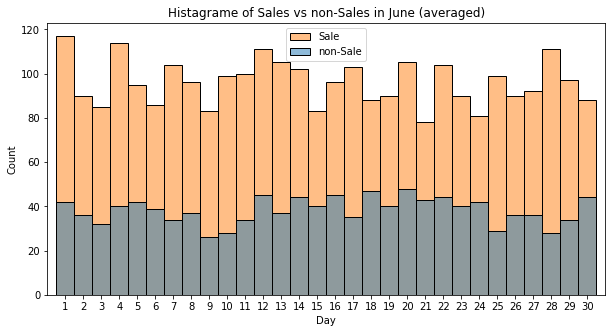

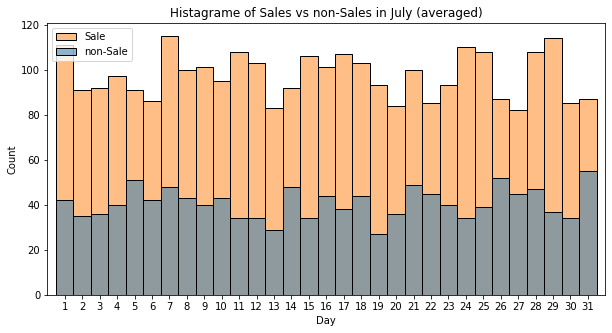

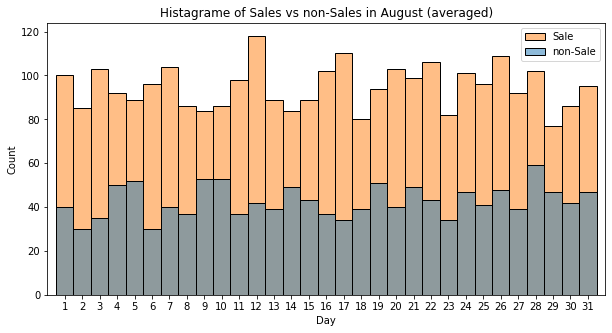

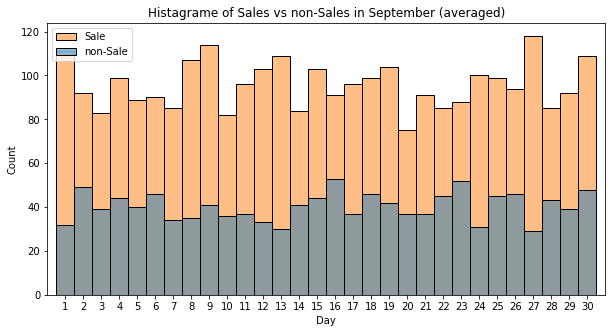

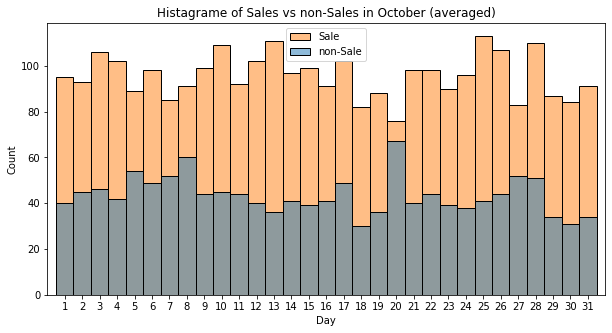

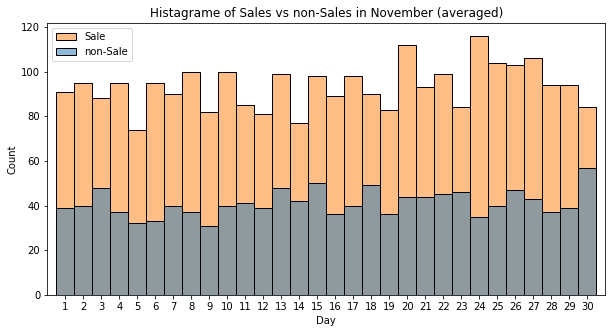

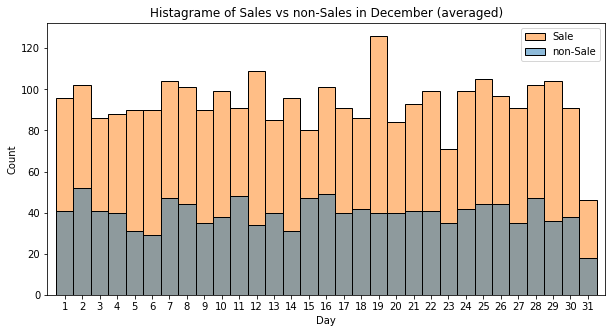

In [34]:
# plots all the months individual days for sale and non-sale:

def plot_months(m,d,i):
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.histplot(data=df_[df_["Month"]==i], x=df_[df_["Month"]==i]["Day"], hue="Sale", bins=np.arange(d+2)-0.5)
    ax.legend(["Sale","non-Sale"], loc='best')
    ax.set_xticks(range(1,d+1))
    ax.set_xlim([0,d+1])
    _=ax.set_title("Histagrame of Sales vs non-Sales in " + m + " (averaged)")

months_days = {"January" : 31, "Febuary" : 28, "March" : 31, "April" : 30,
                "May" : 31, "June" : 30, "July" : 31, "August" : 31,
                "September" : 30, "October" : 31, "November" : 30, "December" : 31}   
i=1
for m,d in months_days.items():
    plot_months(m,d,i)
    i+=1

The above plots show the number of sales vs non-sales for each month. Jan shows the most unique spread with a very high number of customers purchasing insurance on the 30th. December shows the exact opposite of this behaviour. I'm now interested to see if there are any specific weekdays or dates that have a high percentage of purchases compared to non-purchases. 

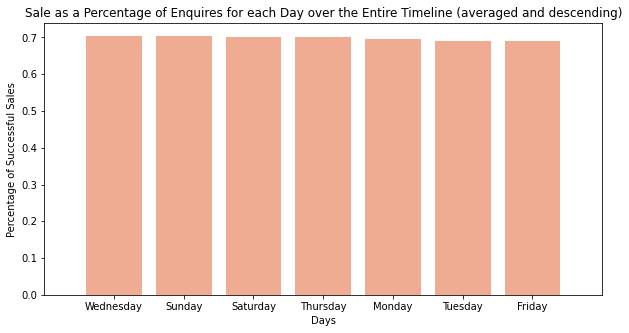

In [35]:
data = df_[["Week Day","Sale"]].groupby("Week Day").mean().sort_values(by="Sale", ascending=False)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=data.index, y=data["Sale"], color = "coral", alpha=0.7, order=data.index)
ax.set_ylabel("Percentage of Successful Sales")
ax.set_xlabel("Days")
ax.set_xticks(range(0,7))
ax.set_xlim([-1,7])
_=ax.set_title("Sale as a Percentage of Enquires for each Day over the Entire Timeline (averaged and descending)")

Very little difference between individual week days sales rates.

Perhaps this vaires more in the individual months?

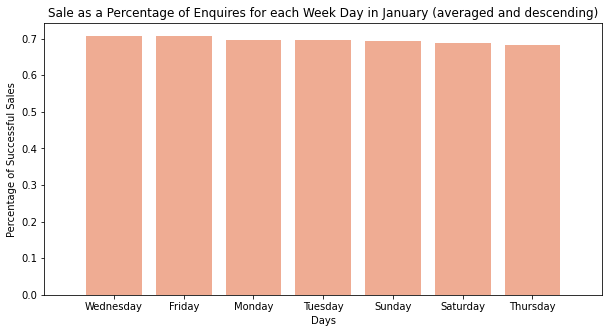

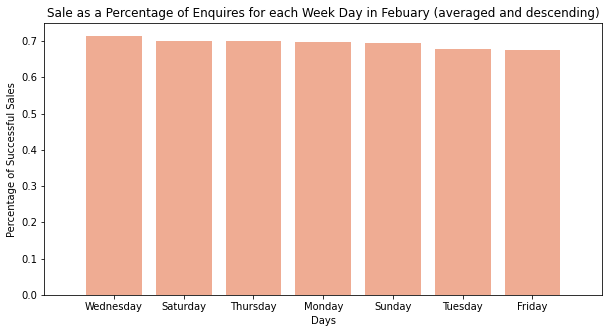

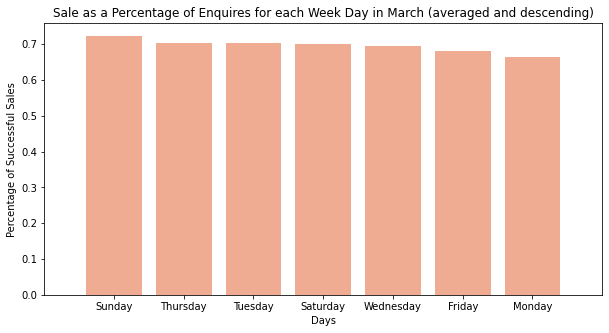

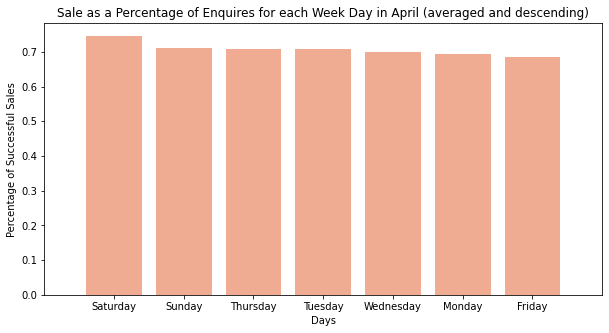

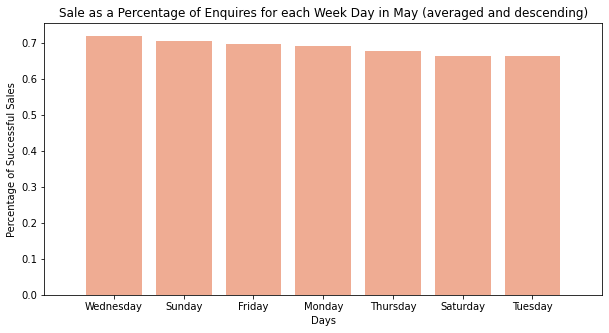

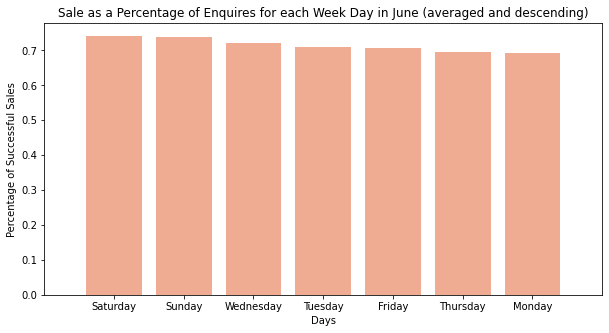

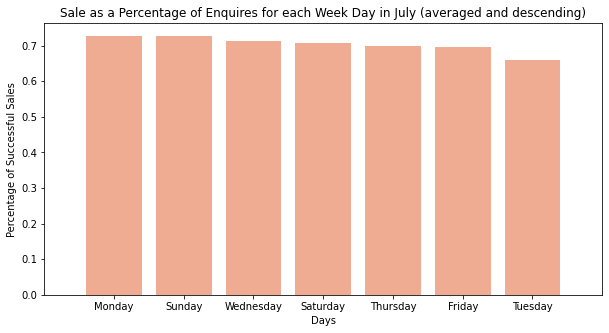

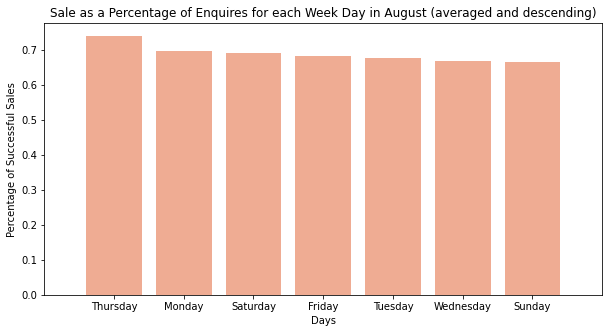

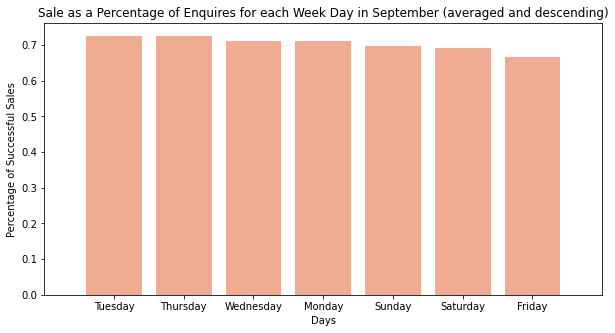

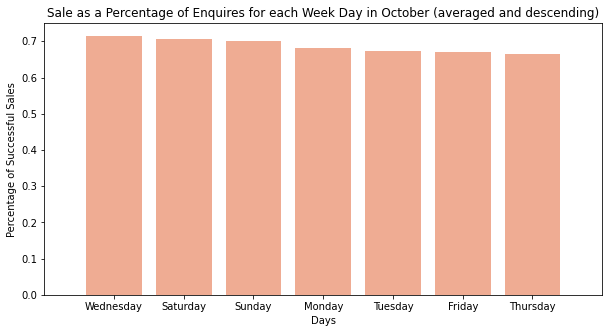

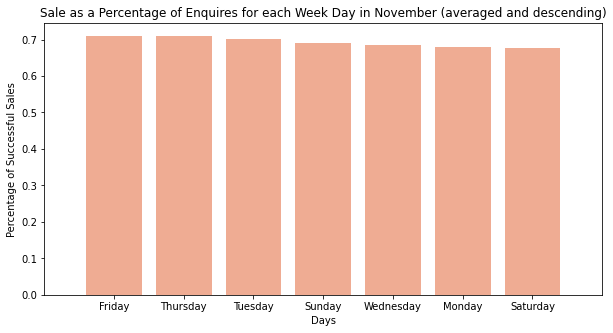

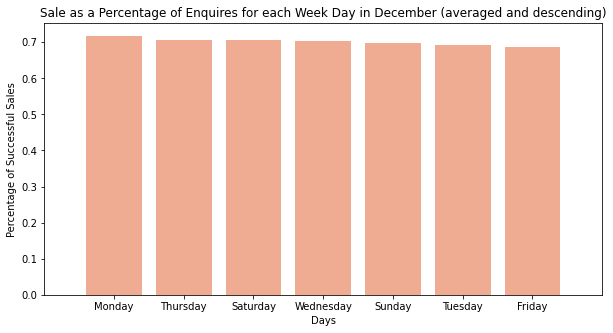

In [36]:
def plot_weekdays(m,i):
    data = df_[df_["Month"]==i][["Week Day","Sale"]].groupby("Week Day").mean().sort_values(by="Sale", ascending=False)
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.barplot(x=data.index, y=data["Sale"], color = "coral", alpha=0.7, order=data.index)
    ax.set_ylabel("Percentage of Successful Sales")
    ax.set_xlabel("Days")
    ax.set_xticks(range(0,7))
    ax.set_xlim([-1,7])
    _=ax.set_title("Sale as a Percentage of Enquires for each Week Day in " + m + " (averaged and descending)")

i=1
for m,d in months_days.items():
    plot_weekdays(m,i)
    i+=1

For most of the months either Friday, Saturday, or Sunday are in the top highest successful sales, however, this is only by a very small margin and might not be statistically significant.

Perhaps there is a specific day that has the highest successful sale rate over the entire time period?

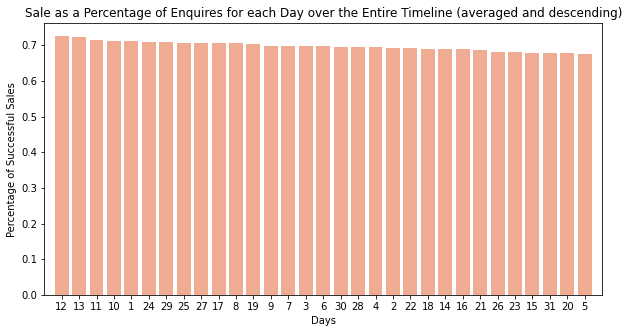

In [37]:
data = df_[["Day","Sale"]].groupby("Day").mean().sort_values(by="Sale", ascending=False)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=data.index, y=data["Sale"], color = "coral", alpha=0.7, order=data.index)
ax.set_ylabel("Percentage of Successful Sales")
ax.set_xlabel("Days")
ax.set_xticks(range(0,31))
ax.set_xlim([-1,31])
_=ax.set_title("Sale as a Percentage of Enquires for each Day over the Entire Timeline (averaged and descending)")

The figure above shows that the 10,11, and 12 have the highest percentage of successful sales. These dates are roughly the second weekend of each month.

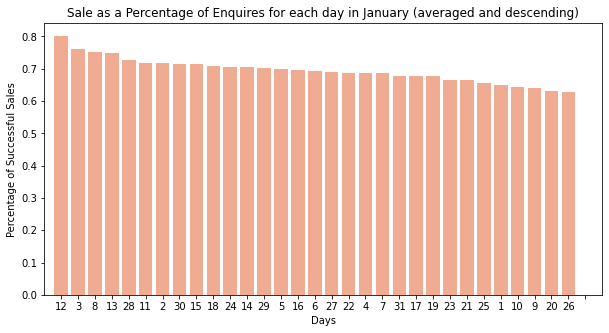

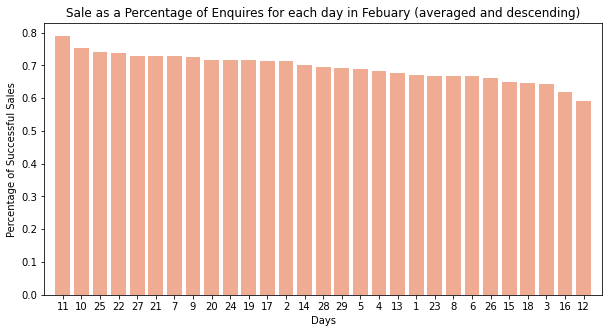

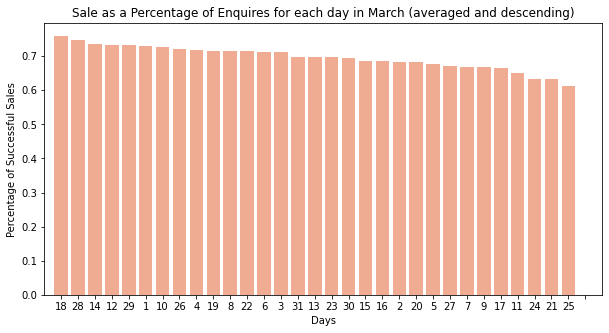

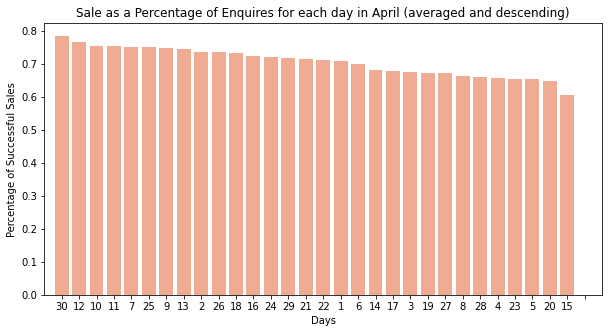

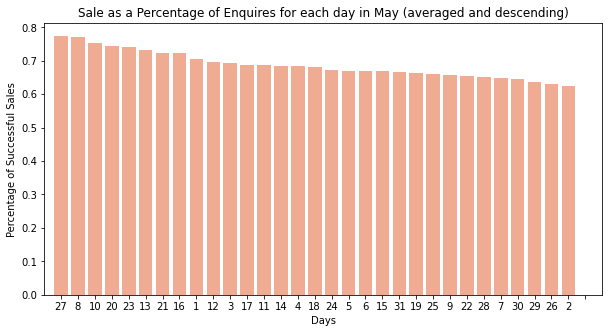

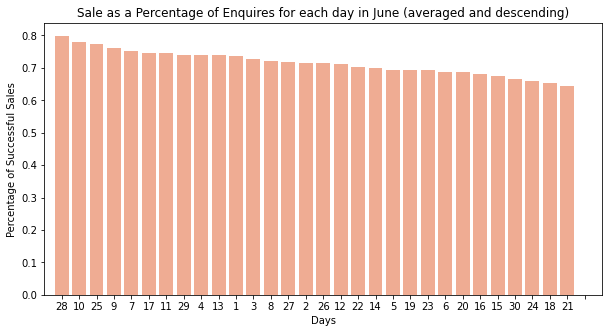

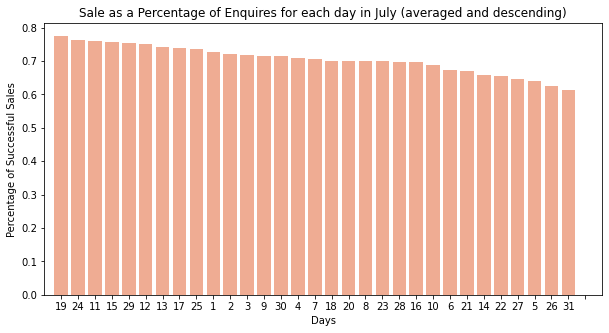

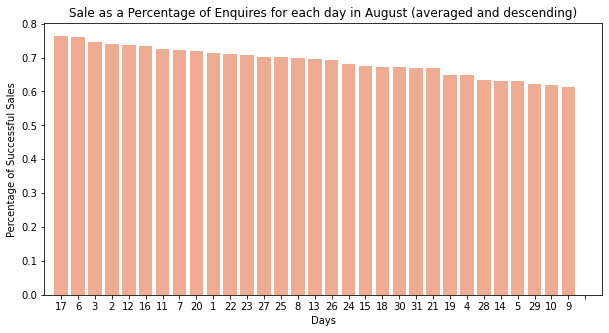

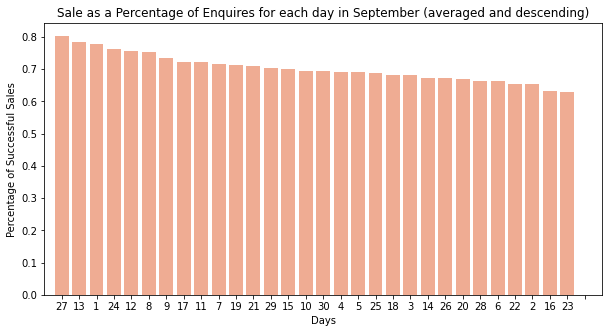

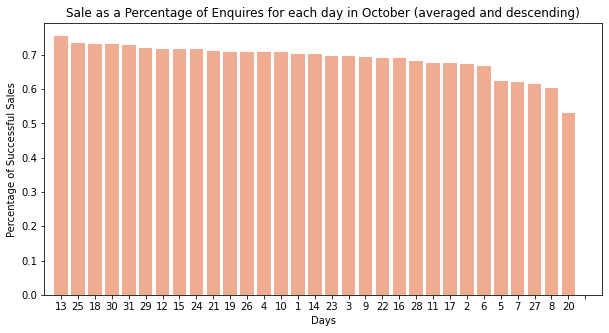

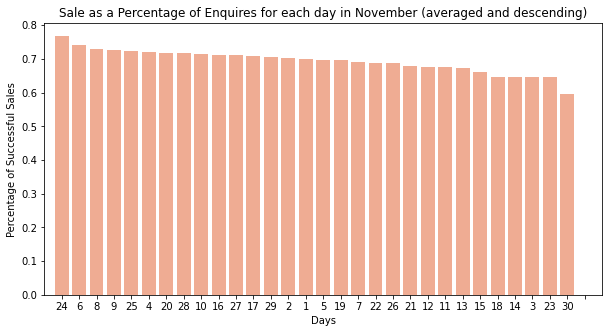

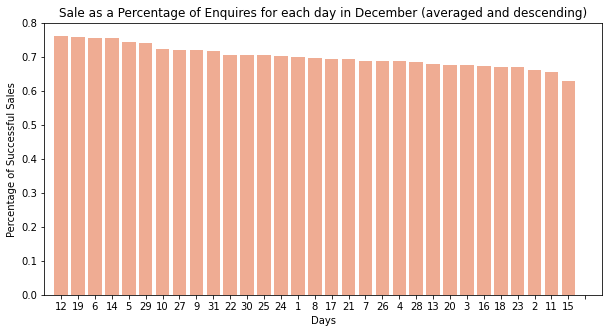

In [38]:
# plots all the months individual days for the percentage of sales vs non-sales:

def plot_months(m,d,i):
    data = df_[df_["Month"]==i][["Day","Sale"]].groupby("Day").mean().sort_values(by="Sale", ascending=False)
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.barplot(x=data.index, y=data["Sale"], color = "coral", alpha=0.7, order=data.index)
    ax.set_ylabel("Percentage of Successful Sales")
    ax.set_xlabel("Days")
    ax.set_xticks(range(0,d+1))
    ax.set_xlim([-1,d+1])
    _=ax.set_title("Sale as a Percentage of Enquires for each day in " + m + " (averaged and descending)")

i=1
for m,d in months_days.items():
    plot_months(m,d,i)
    i+=1

If we consider the top 5 days for each month there is at least 1 date in the final week of the month (except December). Nothing significant has been found from individual dates for each month.

**Investigate Marital Status**

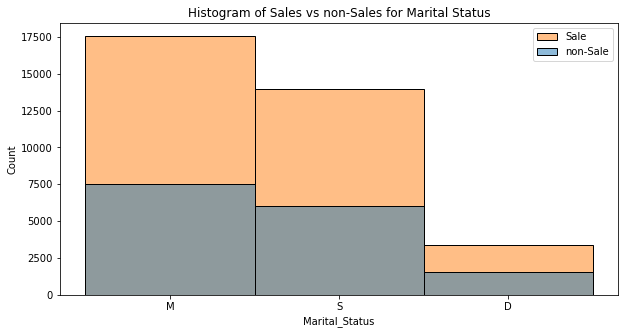

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=df, x="Marital_Status", color="orange", hue="Sale")
ax.legend(["Sale","non-Sale"], loc='upper right')
_=ax.set_title("Histogram of Sales vs non-Sales for Marital Status")

There are more Married customers purchasing insurance. The percentage of sale vs non sale is roughly the same (M=70%, S=69%, D=68%)

**Convert Date and Marital Status into Numeric Data**

For the Date data i will split this into month and date and weekday.

In [40]:
df.head()

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Date,Marital_Status,Sale
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,2016-05-29,M,0
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,2015-07-03,S,0
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,2015-10-04,M,0
3,32.0,10000.0,38.572157,385.721570,7000.0,493.840343,9.165431,2016-09-22,S,0
4,28.0,9000.0,33.317349,333.173490,5000.0,416.459533,6.810972,2015-09-08,M,0


In [41]:
# Marital Status create dummy variables:

Marital = pd.get_dummies(df['Marital_Status'])
df = pd.concat([df,Marital], axis = 1)
df.drop(labels="Marital_Status",axis=1,inplace=True)
df.head(5)

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Date,Sale,D,M,S
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,2016-05-29,0,0,1,0
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,2015-07-03,0,0,0,1
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,2015-10-04,0,0,1,0
3,32.0,10000.0,38.572157,385.721570,7000.0,493.840343,9.165431,2016-09-22,0,0,0,1
4,28.0,9000.0,33.317349,333.173490,5000.0,416.459533,6.810972,2015-09-08,0,0,1,0


In [42]:
# Marital Status create dummy variables:

df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["WeekDay"] = df["Date"].dt.weekday
df.drop(labels="Date", axis=1, inplace=True)
df.head()

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Sale,D,M,S,Month,Day,WeekDay
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,0,0,1,0,5,29,6
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,0,0,0,1,7,3,4
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,0,0,1,0,10,4,6
3,32.0,10000.0,38.572157,385.721570,7000.0,493.840343,9.165431,0,0,0,1,9,22,3
4,28.0,9000.0,33.317349,333.173490,5000.0,416.459533,6.810972,0,0,1,0,9,8,1


I could convert all the Months, Days, and weekdays into dummy variables, however, this would increase my number of features by 55. Instead i can use the fact that the days and months are cyclical and create a sine and cose feature to allow the model to know that the distance between december (12) and january (1) is the same as the distance between january (1) and febuary (2). The same can be done for days of the month. I will plot this below to help illustrate my point:

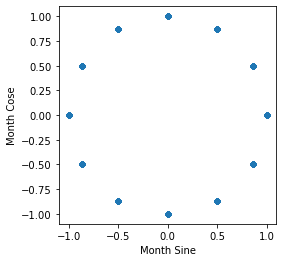

In [43]:
df["Month Sine"] = np.sin(2*np.pi*df.Month/12)
df["Month Cose"] = np.cos(2*np.pi*df.Month/12)
df.drop(labels=["Month"], axis=1, inplace=True)
df.plot.scatter('Month Sine','Month Cose').set_aspect('equal');

Each point in the above figure is a month of the year, where each point shows a month. The plot shows that for all neighbouring months there is equal distance between them.

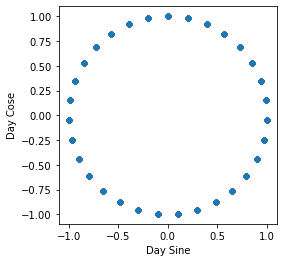

In [44]:
df["Day Sine"] = np.sin(2*np.pi*df.Day/31)
df["Day Cose"] = np.cos(2*np.pi*df.Day/31)
df.drop(labels=["Day"], axis=1, inplace=True)
df.plot.scatter('Day Sine','Day Cose').set_aspect('equal');

The above figure shows the days of each month.

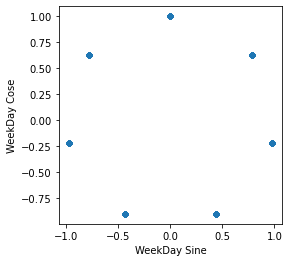

In [45]:
df["WeekDay Sine"] = np.sin(2*np.pi*df.WeekDay/7)
df["WeekDay Cose"] = np.cos(2*np.pi*df.WeekDay/7)
df.drop(labels=["WeekDay"], axis=1, inplace=True)
df.plot.scatter('WeekDay Sine','WeekDay Cose').set_aspect('equal');

The above plot shows the days of the week.

In [46]:
# shows the final dataset:
df.head()

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Sale,D,M,S,Month Sine,Month Cose,Day Sine,Day Cose,WeekDay Sine,WeekDay Cose
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,0,0,1,0,0.500000,-8.660254e-01,-0.394356,0.918958,-0.781831,0.623490
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,0,0,0,1,-0.500000,-8.660254e-01,0.571268,0.820763,-0.433884,-0.900969
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,0,0,1,0,-0.866025,5.000000e-01,0.724793,0.688967,-0.781831,0.623490
3,32.0,10000.0,38.572157,385.721570,7000.0,493.840343,9.165431,0,0,0,1,-1.000000,-1.836970e-16,-0.968077,-0.250653,0.433884,-0.900969
4,28.0,9000.0,33.317349,333.173490,5000.0,416.459533,6.810972,0,0,1,0,-1.000000,-1.836970e-16,0.998717,-0.050649,0.781831,0.623490


**Using a Random Forest to check feature importance**

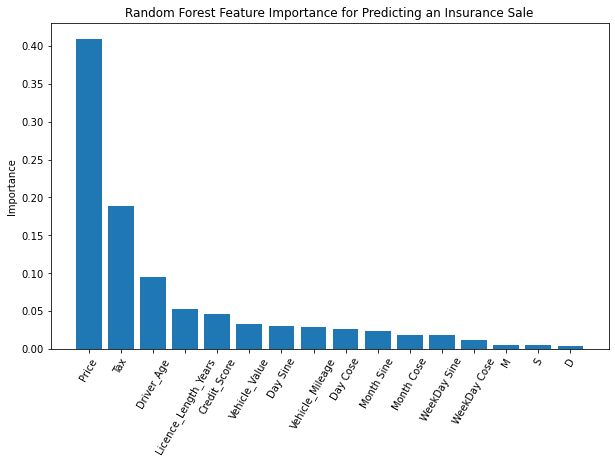

In [47]:
X = df.drop(labels="Sale",axis=1)
Y = df["Sale"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# scaling for a decision tree might not have much impact, as it does not calculate any euclidean distance.
# however, this will be useful for some of the unsupervised learning methods like k-mean-clusters.
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# loop throught some random states and append the feature importance to a dataframe.
df_decision_tree = pd.DataFrame()
for i in range(0,11):
    Dtree = RandomForestClassifier(random_state=i)
    model = Dtree.fit(X_train_scaled, y_train)
    importance = model.feature_importances_
    importance_labels = X.columns

    import_series = pd.Series(data=importance, index=importance_labels).sort_values(ascending=False)
    df_decision_tree[i] = import_series

# refind the dataframe to a series of the mean results from the for loop above
mean_feature = df_decision_tree.T.describe().loc["mean"].sort_values(ascending=False)
_=plt.figure(figsize=(10,6))
_=plt.bar(x=mean_feature.index, height = mean_feature.values)
_=plt.xticks(ticks=range(0,len(list(mean_feature.index))), labels = mean_feature.index, rotation='60')
_=plt.ylabel("Importance")
_=plt.title("Random Forest Feature Importance for Predicting an Insurance Sale")

The above plot shows what features a random forset would pick as the most important features. Unsuprisingly we see that price, tax, and driver age are the best predictor for an insurance Sale and marital status is the least important.

## Machine Learning Section:

I will split the data into train, development (dev), and test. This will allow me to train the model using the training set, test out different hyperparameters using the development set, and then test this model on unseen data. Because the dataset if quite large I can afford to have a larger training set (80%), the other datasets will be 10% each.

I will then scale the data using the standard scalers method which sets the data to have a mean of 0 and standard diviation of 1, this allows for more efficient back propagation and cost function convergence. 

I will use accuracy as my measure of model performance. If i knew how this model would be used it would be easier to choose a performance metric, e.g. if promotions would be sent to customers who are predicted not to purchase a quote then reducing the number of false negatives (increase recall) would be benificial.

reminding them of Hastings offers then precision would be a better metric.

In [51]:
# try using train_test_split
X = df.drop("Sale",axis=1)
Y = df["Sale"]

# train is 80%, dev is 10% and test is 10%
X_train, X_dev_test, y_train, y_dev_test = train_test_split(X, Y, test_size=0.4, random_state=13)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test, y_dev_test, test_size=0.5, random_state=13)

# SMOTE to balance the minority class.
#sm = SMOTE(random_state=1)
#X_train, y_train = sm.fit_resample(X_train, y_train)

# scale data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

**Below is a helper function I will use to report a models performance**

In [52]:
def evaluate(model, train=False, dev=False, test=False):
    # returns train results    
    if train == True:
        name = model
        pred = model.predict(X_train)
        confuction = confusion_matrix(y_train, pred)
        print("-----------------------TRAINING SCORES-----------------------")
        #plot_confusion_matrix(cm=confuction, classes=['Sale', 'No-Sale'], title='Confusion Matrix')
        print(confuction)
        print(str(model)+" accuracy score: {:.2f}".format(accuracy_score(y_train, pred)))
        print(str(model)+" precision score: {:.2f}".format(precision_score(y_train, pred)))
        print(str(model)+" recall score: {:.2f}".format(recall_score(y_train, pred)))
        print(str(model)+" f1 (beta = 1) score: {:.2f}".format(fbeta_score(y_train, pred, beta = 1)))
        print("")
        
    # returns test results
    if dev == True:
        name = model
        pred = model.predict(X_dev)
        confuction = confusion_matrix(y_dev, pred)
        print("----------------------DEVELOPMENT SCORES---------------------")
        print("")
        print(confuction)
        print(str(model)+" accuracy score: {:.2f}".format(accuracy_score(y_dev, pred)))
        print(str(model)+" precision score: {:.2f}".format(precision_score(y_dev, pred)))
        print(str(model)+" recall score: {:.2f}".format(recall_score(y_dev, pred)))
        print(str(model)+" f1 (beta = 1) score: {:.2f}".format(fbeta_score(y_dev, pred, beta = 1)))
        print("")
        
    # completely unseen data
    if test == True:
        name = model
        pred = model.predict(X_test)
        confuction = confusion_matrix(y_test, pred)
        print("-------------------------TEST SCORES-----------------------")
        print("")
        print(confuction)
        print(str(model)+" accuracy score: {:.2f}".format(accuracy_score(y_test, pred)))
        print(str(model)+" precision score: {:.2f}".format(precision_score(y_test, pred)))
        print(str(model)+" recall score: {:.2f}".format(recall_score(y_test, pred)))
        print(str(model)+" f1 (beta = 1) score: {:.2f}".format(fbeta_score(y_test, pred, beta = 1)))

**Dummy Classifier**:

I will use a dummy classifier as a baseline for the models performance. I will use a stratified dummy model which predicts the datas outcome randomly based on the weights of the labelled class.

In [53]:
dummy = DummyClassifier(strategy="stratified").fit(X_train, y_train)
evaluate(dummy, test = True, train= True, dev=True)

-----------------------TRAINING SCORES-----------------------
[[ 2668  6317]
 [ 6270 14745]]
DummyClassifier(strategy='stratified') accuracy score: 0.58
DummyClassifier(strategy='stratified') precision score: 0.70
DummyClassifier(strategy='stratified') recall score: 0.70
DummyClassifier(strategy='stratified') f1 (beta = 1) score: 0.70

----------------------DEVELOPMENT SCORES---------------------

[[ 932 2138]
 [2082 4848]]
DummyClassifier(strategy='stratified') accuracy score: 0.58
DummyClassifier(strategy='stratified') precision score: 0.69
DummyClassifier(strategy='stratified') recall score: 0.70
DummyClassifier(strategy='stratified') f1 (beta = 1) score: 0.70

-------------------------TEST SCORES-----------------------

[[ 909 2137]
 [2032 4922]]
DummyClassifier(strategy='stratified') accuracy score: 0.58
DummyClassifier(strategy='stratified') precision score: 0.70
DummyClassifier(strategy='stratified') recall score: 0.71
DummyClassifier(strategy='stratified') f1 (beta = 1) score: 

Looking at the test scores the model managed to guess correct 58% of the time.

**Default Models**:

In [54]:
# Try a Logistic Regression: This uses a sigmoid function to predict the probability of an event given X.

lr = LogisticRegression().fit(X_train,y_train)
evaluate(lr, train = True, dev= True)

-----------------------TRAINING SCORES-----------------------
[[ 6883  2102]
 [ 1491 19524]]
LogisticRegression() accuracy score: 0.88
LogisticRegression() precision score: 0.90
LogisticRegression() recall score: 0.93
LogisticRegression() f1 (beta = 1) score: 0.92

----------------------DEVELOPMENT SCORES---------------------

[[2358  712]
 [ 506 6424]]
LogisticRegression() accuracy score: 0.88
LogisticRegression() precision score: 0.90
LogisticRegression() recall score: 0.93
LogisticRegression() f1 (beta = 1) score: 0.91



Training and Development scores are very close, meaning there is very low variance in the model, methods such as regularization won't improve performance much. I could try combining features to reduce model bias.

In [55]:
# Try using a Support Vector Classifier: This tries to seperate the data by artificially increasing its dimensions (known as kernel trick)

svc = SVC().fit(X_train, y_train)
evaluate(svc, train = True, dev= True)

-----------------------TRAINING SCORES-----------------------
[[ 6924  2061]
 [ 1082 19933]]
SVC() accuracy score: 0.90
SVC() precision score: 0.91
SVC() recall score: 0.95
SVC() f1 (beta = 1) score: 0.93

----------------------DEVELOPMENT SCORES---------------------

[[2300  770]
 [ 430 6500]]
SVC() accuracy score: 0.88
SVC() precision score: 0.89
SVC() recall score: 0.94
SVC() f1 (beta = 1) score: 0.92



Again, only a very small difference between training scores and development scores. Note: This model takes a long time to run.

In [56]:
# Try a Random forests: these are random combinations of decision trees built by a process called bootstrapping,
# a way of randomly sampling feature.

rf = RandomForestClassifier().fit(X_train,y_train)
evaluate(rf, train = True, dev= True)

-----------------------TRAINING SCORES-----------------------
[[ 8985     0]
 [    0 21015]]
RandomForestClassifier() accuracy score: 1.00
RandomForestClassifier() precision score: 1.00
RandomForestClassifier() recall score: 1.00
RandomForestClassifier() f1 (beta = 1) score: 1.00

----------------------DEVELOPMENT SCORES---------------------

[[2383  687]
 [ 480 6450]]
RandomForestClassifier() accuracy score: 0.88
RandomForestClassifier() precision score: 0.90
RandomForestClassifier() recall score: 0.93
RandomForestClassifier() f1 (beta = 1) score: 0.92



Here the model is overtraining with very low bias, however, there is high variance so some form of regularization can be used to improve performance.

In [57]:
gbdt = GradientBoostingClassifier().fit(X_train, y_train)
evaluate(gbdt, train = True, dev= True)

-----------------------TRAINING SCORES-----------------------
[[ 7097  1888]
 [ 1223 19792]]
GradientBoostingClassifier() accuracy score: 0.90
GradientBoostingClassifier() precision score: 0.91
GradientBoostingClassifier() recall score: 0.94
GradientBoostingClassifier() f1 (beta = 1) score: 0.93

----------------------DEVELOPMENT SCORES---------------------

[[2391  679]
 [ 458 6472]]
GradientBoostingClassifier() accuracy score: 0.89
GradientBoostingClassifier() precision score: 0.91
GradientBoostingClassifier() recall score: 0.93
GradientBoostingClassifier() f1 (beta = 1) score: 0.92



In [58]:
# A simple model which learns the k neighbouring data points using the euclidean distance between them.

knc = KNeighborsClassifier().fit(X_train, y_train)
evaluate(knc, train = True, dev= True)

-----------------------TRAINING SCORES-----------------------
[[ 6788  2197]
 [  921 20094]]
KNeighborsClassifier() accuracy score: 0.90
KNeighborsClassifier() precision score: 0.90
KNeighborsClassifier() recall score: 0.96
KNeighborsClassifier() f1 (beta = 1) score: 0.93

----------------------DEVELOPMENT SCORES---------------------

[[1986 1084]
 [ 501 6429]]
KNeighborsClassifier() accuracy score: 0.84
KNeighborsClassifier() precision score: 0.86
KNeighborsClassifier() recall score: 0.93
KNeighborsClassifier() f1 (beta = 1) score: 0.89



**Which Models to Try Hyperparameter Tuning On?**
- Random Forests performed extremely well on the training set, and relatively well on the development set. Perhaps using some form of regularization could improve this development score (reduce variance).
- Logistic regression had very low variance, meaning that regularization would have little effect on performance. I dont think that hyperparameter tuning will improve performance much.
- SVC performed similarly to the Logistic regression but takes much longer to run (better suited for large sparse datasets)

I will take the Random Forest model, Logistic Regresson, and SVM forwards for hyperparameter tuning as these showed the best training and test scores.

**Hyerparameter Tuning:**

For all the models i will try searching for hyperparameters that i think could improve performance. I will then select the hyperparameters that result in the best accuracy and run cross validation on this model with these hyperparameters to better see how the model will perform with different training and test data, the scores returns will be the mean of these cross validations scores.

In [552]:
# Random Forest:

grid = {"n_estimators": [10,50,100,300,600,1000],
       "max_depth":[3,5,10,30,None]}

grid_rf_model = GridSearchCV(RandomForestClassifier(), param_grid = grid, n_jobs=-2)
grid_rf_model.fit(X_train, y_train)

params_rf = grid_rf_model.best_params_

rf_best_model = RandomForestClassifier(n_estimators=params_rf["n_estimators"], max_depth=params_rf["max_depth"])

cross_val_score_rf_best = cross_val_score(rf_best_model, X, Y, cv=5, n_jobs=-2)

In [553]:
rf_best_model.fit(X_train, y_train)
evaluate(rf_best_model, train = True, dev= True)

-----------------------TRAINING SCORES-----------------------
[[ 8985     0]
 [    0 21015]]
RandomForestClassifier(max_depth=30, n_estimators=600) accuracy score: 1.00
RandomForestClassifier(max_depth=30, n_estimators=600) precision score: 1.00
RandomForestClassifier(max_depth=30, n_estimators=600) recall score: 1.00
RandomForestClassifier(max_depth=30, n_estimators=600) f1 (beta = 1) score: 1.00

----------------------DEVELOPMENT SCORES---------------------

[[2373  697]
 [ 458 6472]]
RandomForestClassifier(max_depth=30, n_estimators=600) accuracy score: 0.88
RandomForestClassifier(max_depth=30, n_estimators=600) precision score: 0.90
RandomForestClassifier(max_depth=30, n_estimators=600) recall score: 0.93
RandomForestClassifier(max_depth=30, n_estimators=600) f1 (beta = 1) score: 0.92



Trying many different hyperparameters (not just the ones shown), I can't reduce the variance between training and testing. I thought that maybe reducing the depth of trees could act as some form of regularizations, however this just reduced performance of both the test and training data.

In [587]:
# Logistic Regression:

grid = {"C": [0.001,0.01,0.1,0.2,0.5,1,2]}

grid_lr_model = GridSearchCV(LogisticRegression(), param_grid = grid, n_jobs=-2)
grid_lr_model.fit(X_train, y_train)

params_lr = grid_lr_model.best_params_

lr_best_model = LogisticRegression(C=params_lr["C"])

cross_val_score_lr_best = cross_val_score(lr_best_model, X, Y, cv=5, n_jobs=-2)

In [588]:
lr_best_model.fit(X_train, y_train)
evaluate(lr_best_model, train = True, dev= True)

-----------------------TRAINING SCORES-----------------------
[[ 6874  2111]
 [ 1487 19528]]
LogisticRegression(C=0.1) accuracy score: 0.88
LogisticRegression(C=0.1) precision score: 0.90
LogisticRegression(C=0.1) recall score: 0.93
LogisticRegression(C=0.1) f1 (beta = 1) score: 0.92

----------------------DEVELOPMENT SCORES---------------------

[[2356  714]
 [ 501 6429]]
LogisticRegression(C=0.1) accuracy score: 0.88
LogisticRegression(C=0.1) precision score: 0.90
LogisticRegression(C=0.1) recall score: 0.93
LogisticRegression(C=0.1) f1 (beta = 1) score: 0.91



In [589]:
# SVM:

grid = {"kernel": ["rbf","poly"],
       "C":[0.01,0.1,1,2,5,10]}

grid_svm_model = GridSearchCV(SVC(), param_grid = grid, n_jobs=-2)
grid_svm_model.fit(X_train, y_train)

params_svm = grid_svm_model.best_params_

svm_best_model = SVC(C=params_svm["C"], kernel=params_svm["kernel"])

cross_val_score_svm_best = cross_val_score(svm_best_model, X, Y, cv=5, n_jobs=-2)

In [590]:
svm_best_model.fit(X_train, y_train)
evaluate(svm_best_model, train = True, dev= True)

-----------------------TRAINING SCORES-----------------------
[[ 6869  2116]
 [ 1088 19927]]
SVC(C=1) accuracy score: 0.89
SVC(C=1) precision score: 0.90
SVC(C=1) recall score: 0.95
SVC(C=1) f1 (beta = 1) score: 0.93

----------------------DEVELOPMENT SCORES---------------------

[[2289  781]
 [ 416 6514]]
SVC(C=1) accuracy score: 0.88
SVC(C=1) precision score: 0.89
SVC(C=1) recall score: 0.94
SVC(C=1) f1 (beta = 1) score: 0.92



For all the models hyperparameter tuning results in negligible performance increases. I think that the best way to further improve the model performance would be throught feature engineering, perhaps combining the top 5 most important features together to form new features could improve performance, or gathering more data.

The model with the best performance is the Gradient Boosting Classifier with an accuracy of 89% on development set. It doesnt show in this notebook but tried the model with many different hyperparameters but found no model performance increase. The default model showed the best performance.

In [71]:
gbdt = GradientBoostingClassifier().fit(X_train, y_train)
evaluate(gbdt, train = True, dev= True, test=True)

-----------------------TRAINING SCORES-----------------------
[[ 7097  1888]
 [ 1223 19792]]
GradientBoostingClassifier() accuracy score: 0.90
GradientBoostingClassifier() precision score: 0.91
GradientBoostingClassifier() recall score: 0.94
GradientBoostingClassifier() f1 (beta = 1) score: 0.93

----------------------DEVELOPMENT SCORES---------------------

[[2391  679]
 [ 458 6472]]
GradientBoostingClassifier() accuracy score: 0.89
GradientBoostingClassifier() precision score: 0.91
GradientBoostingClassifier() recall score: 0.93
GradientBoostingClassifier() f1 (beta = 1) score: 0.92

-------------------------TEST SCORES-----------------------

[[2388  658]
 [ 416 6538]]
GradientBoostingClassifier() accuracy score: 0.89
GradientBoostingClassifier() precision score: 0.91
GradientBoostingClassifier() recall score: 0.94
GradientBoostingClassifier() f1 (beta = 1) score: 0.92


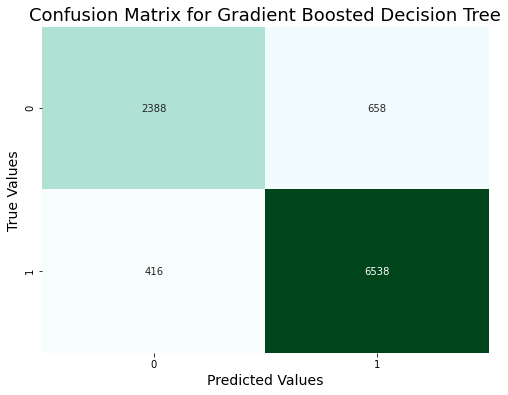

In [70]:
gbdt = GradientBoostingClassifier().fit(X_train, y_train)
gbdt_pred = gbdt.predict(X_test)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, gbdt_pred),
            annot=True, fmt='g', cmap="BuGn", cbar=False)

_=plt.xlabel("Predicted Values", fontsize=14)
_=plt.ylabel("True Values", fontsize=14)
_=plt.title("Confusion Matrix for Gradient Boosted Decision Tree", fontsize=18)

On completely unseen data the selected model shows an accuracy of 89%, precision of 91%, recall of 94%, and f1 (a combination of recall and precision) of 92%.

# Results:

**EDA Findings:**
- Price and Tax has two linear relationships, this might be some form of VAT on the insurance quote that changed on some date around july 2015.
- Price, Tax, and Driver age are the most important features for deciding who will purchase insurance and who wont. Suprisingly as price increases so does the likelihood of a customer purchasing insurance. Younger customers are also more likely to purchase insurance from Hastings.
- Credit Score shows little correlation, meaning that as credit score goes up or down a customers likelihood of purchasing doesnt change, however, combinding credit score with other features (e.g. price, tax, driver age) allows for decent seperation of sale and non-sale.
- Over the entire time period insurance purchases havn't really increased, and the percentage of successful sales has hardly changed.
- Over the months sales stay roughly the same, however, at the end of the month more customers purchase and enquire about insurance. This is especially true for January and not true for December.
- The highest percentage of successful insurance quotes seem to occur around the second weekend for most months (needs to be comfired statistically however).

**Machine Learning:**
- Using a Dummy Classifier on the dataset resulted in accuracy of 58%.
- Performing hyperparameter tuning on some ML models showed minimal accuracy improvements.
- Oversampling the minority class (non-sales) resulted in minimal model improvements, so this method was not used.
- The best peforming models was the Gradient Boosted Decision Tree with default hyperparamters. This model achieved an accuracy of 89%, precision of 91%, recall of 94%, and an f1 score of 92%.

**Potential Improvements:**
- Gathering more data. Having features such as time spend on webpage, number of times revisiting the quote, number and type of vehicle, and type of insurance could have been useful features.
- If I had more time combining features to make new features could have improved model performance.
- I would have liked to use deep learning on this dataset, I beleive that with the size of data a nerual network would almost definitely outperform standard machine learning techniques.